In [1]:
from itertools import chain
from matplotlib import cm
import matplotlib.pyplot as plt

# from cartopy.mpl.geoaxes import GeoAxes
import numpy as np
from obspy.signal.tf_misfit import plot_tfr
from lasif.exceptions import LASIFError
import cmasher as cmr
from typing import Union, List, Dict 
import cartopy.crs as ccrs
from glob import glob
import pandas as pd
import cartopy as cp
def project_points(
    projection,
    lon: Union[np.ndarray, float],
    lat: Union[np.ndarray, float],
):
    """
    Define the correct projection function depending on name of projection
    :param projection: Projection to be used
    :type projection: cp.crs.Projection
    :param lon: Longitude coordinate
    :type lon: Union[np.ndarray, float]
    :param lat: Latitude coordinate
    :type lat: Union[np.ndarray, float]
    :return: projected lon, lat points
    :rtype: np.ndarray, np.ndarray
    """
    import pyproj
    import cartopy as cp

    proj_dict = projection.proj4_params

    # projection = pyproj.crs.CRS.from_dict(proj_dict)
    event_loc = pyproj.Proj(proj_dict, preserve_units=True)
    x, y = event_loc(lon, lat)
    if isinstance(x, list):
        x = np.array(x)
        y = np.array(y)
    return x, y
def plot_raydensity(
    map_object,
    station_events: list,
    projection,
):
    """
    Create a ray-density plot for all events and all stations.
    This function is potentially expensive and will use all CPUs available.
    Does require geographiclib to be installed.
    :param map_object: The cartopy domain plot object
    :type map_object: cp.mpl.geoaxes.GeoAxes
    :param station_events: A list of tuples with two dictionaries
    :type station_events: List[Tuple[dict, dict]]
    :param projection: cartopy projection object
    :type projection: cp.crs.Projection
    """
    import ctypes as C
    from lasif.tools.great_circle_binner import GreatCircleBinner
    from lasif.utils import Point
    import multiprocessing
    import progressbar
    from scipy.stats import scoreatpercentile
    import cartopy as cp

    # Merge everything so that a list with coordinate pairs is created. This
    # list is then distributed among all processors.
    station_event_list = []
    for event, station in station_events:
      #  print(event)
      #  print(station)
        e_point = Point(event["latitude"], event["longitude"])
        #for station in stations.values():
        p = Point(station["latitude"], station["longitude"])
        station_event_list.append((e_point, p))

    circle_count = len(station_event_list)

    # The granularity of the latitude/longitude discretization for the
    # raypaths. Attempt to get a somewhat meaningful result in any case.
    if circle_count < 1000:
        lat_lng_count = 1000
    elif circle_count < 10000:
        lat_lng_count = 2000
    else:
        lat_lng_count = 3000

    cpu_count = multiprocessing.cpu_count()

    def to_numpy(raw_array, dtype, shape):
        data = np.frombuffer(raw_array.get_obj())
        data.dtype = dtype
        return data.reshape(shape)

    print(
        "\nLaunching %i great circle calculations on %i CPUs..."
        % (circle_count, cpu_count)
    )

    widgets = [
        "Progress: ",
        progressbar.Percentage(),
        progressbar.Bar(),
        "",
        progressbar.ETA(),
    ]
    pbar = progressbar.ProgressBar(
        widgets=widgets, maxval=circle_count
    ).start()

    def great_circle_binning(
        sta_evs, bin_data_buffer, bin_data_shape, lock, counter
    ):
        new_bins = GreatCircleBinner(
            -89.,
            89.,
            lat_lng_count,
            -180.,
            180.,
            lat_lng_count,
        )
        for event, station in sta_evs:
            with lock:
                counter.value += 1
            if not counter.value % 25:
                pbar.update(counter.value)
            new_bins.add_greatcircle(event, station)

        bin_data = to_numpy(bin_data_buffer, np.uint32, bin_data_shape)
        with bin_data_buffer.get_lock():
            bin_data += new_bins.bins

    # Split the data in cpu_count parts.
    def chunk(seq, num):
        avg = len(seq) / float(num)
        out = []
        last = 0.0
        while last < len(seq):
            out.append(seq[int(last) : int(last + avg)])
            last += avg
        return out

    chunks = chunk(station_event_list, cpu_count)

    # One instance that collects everything.
    collected_bins = GreatCircleBinner(
        -89.,
        89.,
        lat_lng_count,
        -180.,
        180.,
        lat_lng_count,
    )

    # Use a multiprocessing shared memory array and map it to a numpy view.
    collected_bins_data = multiprocessing.Array(
        C.c_uint32, collected_bins.bins.size
    )
    collected_bins.bins = to_numpy(
        collected_bins_data, np.uint32, collected_bins.bins.shape
    )

    # Create, launch and join one process per CPU. Use a shared value as a
    # counter and a lock to avoid race conditions.
    processes = []
    lock = multiprocessing.Lock()
    counter = multiprocessing.Value("i", 0)
    for _i in range(cpu_count):
        processes.append(
            multiprocessing.Process(
                target=great_circle_binning,
                args=(
                    chunks[_i],
                    collected_bins_data,
                    collected_bins.bins.shape,
                    lock,
                    counter,
                ),
            )
        )
    for process in processes:
        process.start()
    for process in processes:
        process.join()

    pbar.finish()

    stations = chain.from_iterable(
        (_i[1].values() for _i in station_events if _i[1])
    )
    # Remove duplicates
    #stations = [(_i["latitude"], _i["longitude"]) for _i in stations]
    #stations = set(stations)
    #title = "%i Events, %i unique raypaths, " "%i unique stations" % (
    #    len(station_events),
    #    circle_count,
    #    len(stations),
    #)
    #plt.title(title, size="xx-large")

    data = collected_bins.bins.transpose()

    if data.max() >= 10:
        data = np.log10(np.clip(data, a_min=0.5, a_max=data.max()))
        data[data >= 0.0] += 0.1
        data[data < 0.0] = 0.0
        max_val = scoreatpercentile(data.ravel(), 99.99)
    else:
        max_val = data.max()

    cmap = cm.get_cmap("gist_heat")
#     cmap = cm.get_cmap("gist_gray_r")
    cmap._init()
    cmap._lut[:120, -1] = np.linspace(0, 1.0, 120) ** 2

    lngs, lats = collected_bins.coordinates
    ln, la = project_points(projection, lngs, lats)

    map_object.pcolormesh(
        ln, la, data, cmap=cmap, vmin=0, vmax=max_val, zorder=10,# alpha = 1.0
    )
    # Draw the coastlines so they appear over the rays. Otherwise things are
    # sometimes hard to see.
#     map_object.add_feature(cp.feature.COASTLINE, zorder=13)
#     map_object.add_feature(cp.feature.BORDERS, linestyle=":", zorder=13)
    
    return map_object

39164 /Users/sebastiannoe/Workspace/csemlib/data/Data/2022_Western_US
2604 /Users/sebastiannoe/Workspace/csemlib/data/Data/2017_Japan
2919 /Users/sebastiannoe/Workspace/csemlib/data/Data/2019_Iran
18588 /Users/sebastiannoe/Workspace/csemlib/data/Data/2022_South_East_Asia
2523 /Users/sebastiannoe/Workspace/csemlib/data/Data/2017_South_East_Asia
6917 /Users/sebastiannoe/Workspace/csemlib/data/Data/2016_Japan
32412 /Users/sebastiannoe/Workspace/csemlib/data/Data/2021_Africa
20072 /Users/sebastiannoe/Workspace/csemlib/data/Data/2017_Global
14026 /Users/sebastiannoe/Workspace/csemlib/data/Data/2013_Europe
10575 /Users/sebastiannoe/Workspace/csemlib/data/Data/2019_Eastern_Mediterranean
6513 /Users/sebastiannoe/Workspace/csemlib/data/Data/2013_Anatolia
78510 /Users/sebastiannoe/Workspace/csemlib/data/Data/2017_North_America
4103 /Users/sebastiannoe/Workspace/csemlib/data/Data/2013_North_Atlantic
523435 /Users/sebastiannoe/Workspace/csemlib/data/Data/2021_China
2649 /Users/sebastiannoe/Workspa

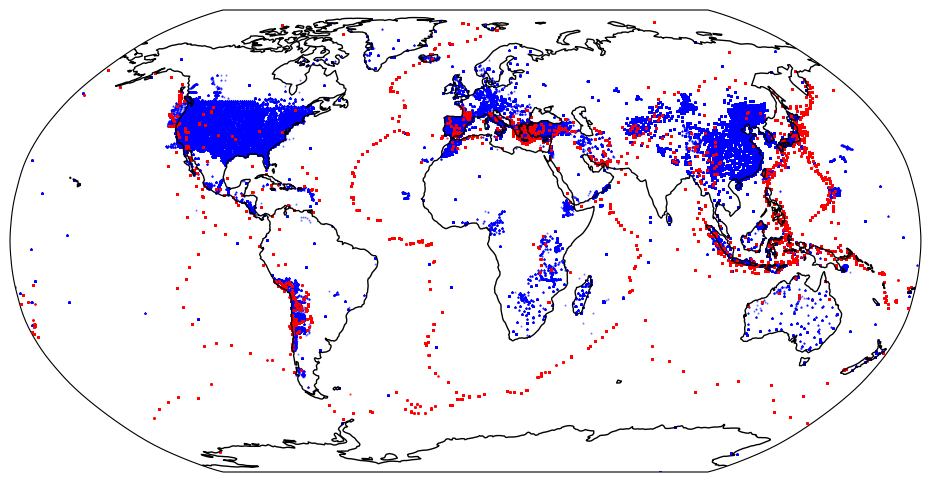

In [7]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
datalist = glob("/Users/sebastiannoe/Workspace/csemlib/data/Data/*")
datalist.remove("/Users/sebastiannoe/Workspace/csemlib/data/Data/dataset_list.yml")

station_events = []
#data = ### SRC_LAT, SRC_LON, REC_LAT, REC_LON
count = 0

for region in datalist:
    
    if 'MESWA' in region or 'EUWA' in region or '2023_Turkey' in region:
        print('SKIP', region)
        continue
    
    rays_file = glob(region+'/rays.txt')[0]
    data = np.loadtxt(rays_file)
    src_lat = data[:,0]
    src_lon = data[:,1]
    rec_lat = data[:,2]
    rec_lon = data[:,3]
    print(len(data), region)
    count += len(data)
    for i in range(len(data)):
        station_events.append(({'longitude':src_lon[i], 'latitude':src_lat[i]},
                               {'longitude':rec_lon[i], 'latitude': rec_lat[i]}))
        
    ax.scatter(src_lon, src_lat, 1, marker='.', c='r', alpha = 0.5,transform=ccrs.PlateCarree(), zorder = 11)
    ax.scatter(rec_lon, rec_lat, 0.25, marker='^', c='b', alpha = 0.5, transform=ccrs.PlateCarree(), zorder = 10)

print(f'Total of {count} source-receiver pairs in regions.')
    
ax.add_feature(cp.feature.COASTLINE, zorder = 13)

plt.savefig('Rayplots/CSEM_source_receiver_configuration.jpg',  bbox_inches='tight', dpi=1500)
plt.show()

39164 /Users/sebastiannoe/Workspace/csemlib/data/Data/2022_Western_US
2604 /Users/sebastiannoe/Workspace/csemlib/data/Data/2017_Japan
2919 /Users/sebastiannoe/Workspace/csemlib/data/Data/2019_Iran
18588 /Users/sebastiannoe/Workspace/csemlib/data/Data/2022_South_East_Asia
2523 /Users/sebastiannoe/Workspace/csemlib/data/Data/2017_South_East_Asia
6917 /Users/sebastiannoe/Workspace/csemlib/data/Data/2016_Japan
32412 /Users/sebastiannoe/Workspace/csemlib/data/Data/2021_Africa
20072 /Users/sebastiannoe/Workspace/csemlib/data/Data/2017_Global
14026 /Users/sebastiannoe/Workspace/csemlib/data/Data/2013_Europe
10575 /Users/sebastiannoe/Workspace/csemlib/data/Data/2019_Eastern_Mediterranean
6513 /Users/sebastiannoe/Workspace/csemlib/data/Data/2013_Anatolia
78510 /Users/sebastiannoe/Workspace/csemlib/data/Data/2017_North_America
4103 /Users/sebastiannoe/Workspace/csemlib/data/Data/2013_North_Atlantic
523435 /Users/sebastiannoe/Workspace/csemlib/data/Data/2021_China
2649 /Users/sebastiannoe/Workspa


Launching 797030 great circle calculations on 16 CPUs...


Progress: 100%|######################################################################################################################################################################################|Time: 0:16:27


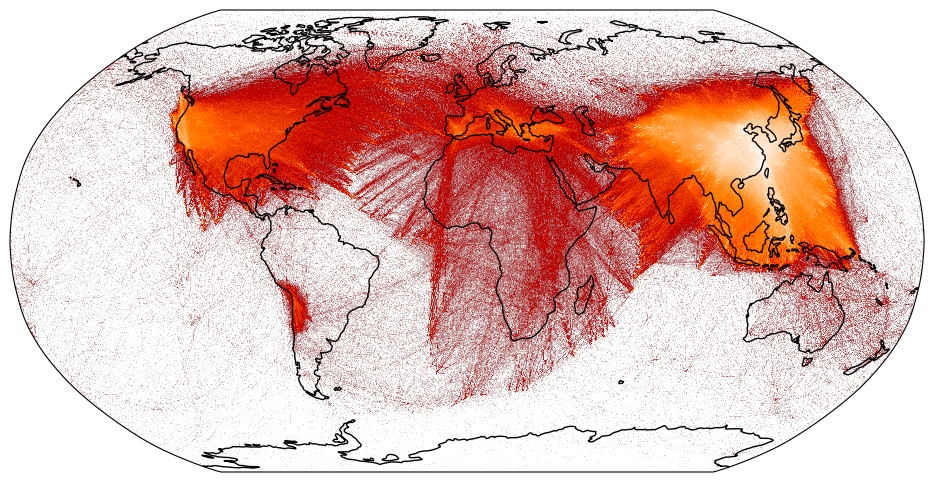

In [8]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
datalist = glob("/Users/sebastiannoe/Workspace/csemlib/data/Data/*")
datalist.remove("/Users/sebastiannoe/Workspace/csemlib/data/Data/dataset_list.yml")

station_events = []
#data = ### SRC_LAT, SRC_LON, REC_LAT, REC_LON
for region in datalist:
    
    if 'MESWA' in region or 'EUWA' in region or '2023_Turkey' in region:
        print('SKIP', region)
        continue
        
    rays_file = glob(region+'/rays.txt')[0]
    data = np.loadtxt(rays_file)
    src_lat = data[:,0]
    src_lon = data[:,1]
    rec_lat = data[:,2]
    rec_lon = data[:,3]
    print(len(data), region)
    for i in range(len(data)):
        station_events.append(({'longitude':src_lon[i], 'latitude':src_lat[i]},
                               {'longitude':rec_lon[i], 'latitude': rec_lat[i]}))
        
#     ax.scatter(src_lon, src_lat, 0.1, marker='.', c='r', alpha = 0.25,transform=ccrs.PlateCarree(), zorder = 11)
#     ax.scatter(rec_lon, rec_lat, 1, marker='^', c='b', alpha = 0.5, transform=ccrs.PlateCarree(), zorder = 10)

ax = plot_raydensity(ax, station_events, projection = ccrs.Robinson(central_longitude=0))    
ax.add_feature(cp.feature.COASTLINE, zorder = 13)

plt.savefig('Rayplots/CSEM_raypaths.jpg',  bbox_inches='tight', dpi=1500)
plt.show()